## Removal of batch effects using distribution-matching residual networks
In this notebook we apply [recently published apporach for batch effect removal](https://academic.oup.com/bioinformatics/article-abstract/doi/10.1093/bioinformatics/btx196/3611270/Removal-of-batch-effects-using-distribution) to [data made available](https://github.com/jdblischak/singleCellSeq) by [Tung et al.](https://www.nature.com/articles/srep39921).

In [47]:
# General imports
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ML & NN inports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, merge, Activation, add
from keras.regularizers import l2
from keras import initializers

### Load scRNA read counts
The data has been filtered to remove all-zero rows and "ERCC" spike-in controls (see `prepare_data.Rmd`). We use only data for one patient and two corresponding batches

In [16]:
batch1 = np.genfromtxt("batch1_genes.txt", delimiter = ",", skip_header = 0)
batch2 = np.genfromtxt("batch2_genes.txt", delimiter = ",", skip_header = 0)

In [23]:
source = np.concatenate((batch1, batch2), axis = 1)
labels = np.ones(source.shape[1])
labels[batch1.shape[1]:-1] = 2
len(labels), source.shape

(142, (13058, 142))

#### Preprocessing
We extract first 37 PCs of the data in order to preserve the same dimensionality that was used to train the ResNet model. This allows us to directly load pretrained weights. We also apply `log(counts + 1)` normalization, mean subtraction and transform data to have unit variance, all in accordance with approach in the [paper](https://academic.oup.com/bioinformatics/article-abstract/doi/10.1093/bioinformatics/btx196/3611270/Removal-of-batch-effects-using-distribution)

In [24]:
# PCA
PCA_obj = PCA(n_components = 37).fit(source)
source = PCA_obj.transform(source)
source.shape

(13058, 37)

In [18]:
# Preprocess
source = np.log(1+source)
preprocessor = StandardScaler().fit(source)
source = preprocessor.transform(source) 

#### Define plotting functions

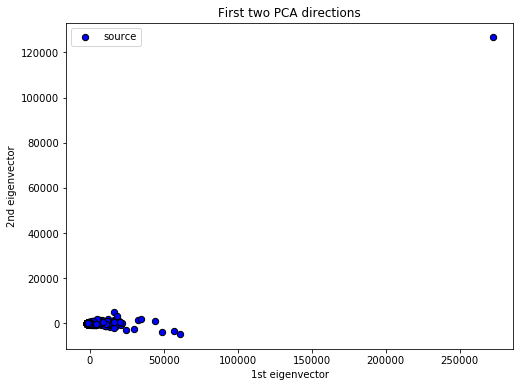

In [73]:
# plot the first two PCA dimensions
def plot_pca_2d(source, calibratedSource = np.empty(0)):
    indices = np.unique(np.random.randint(0, source.shape[0] - 1, 1000))

    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.scatter(source[indices, 0], source[indices, 1], cmap=plt.cm.Set1, c = "b", edgecolor='k', 
               s=40, label = "source")
    if calibratedSource.size:
        ax.scatter(calibratedSource[indices, 0], calibratedSource[indices, 1],
                   cmap=plt.cm.Set1, c = "r", edgecolor='k',s=40, label = "calibratedSource")

    ax.set_title("First two PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.set_ylabel("2nd eigenvector")
    plt.legend()
    plt.show()
    return fig

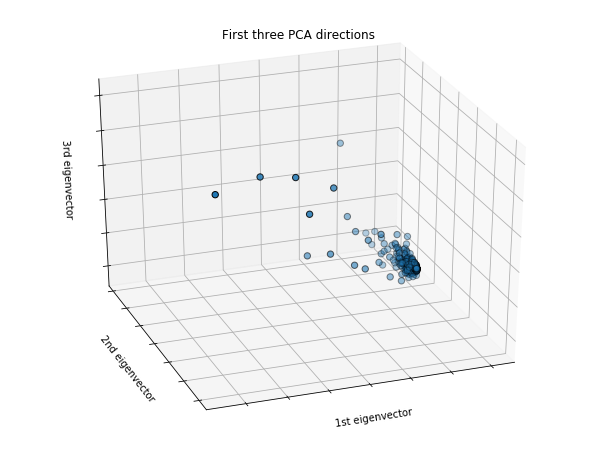

In [63]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
def plot_pca_3d(source):
    indices = np.unique(np.random.randint(0, source.shape[0] - 1, 1000))

    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(source[indices, 0], source[indices, 1], source[indices, 2],
               cmap=plt.cm.Set1, edgecolor='k', s=40)

    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    plt.show()


### Train ResNet
We follow approach as in `src/train_MMD_ResNet.py` script, but we omit the training of the neural net and instead load weights previously obtained on [different dataset](https://github.com/broadinstitute/BipolarCell2016).

** My questions: **
- would it work also with different layer size?
- would it work without dimensionality reduction to 37?

In [ ]:
#ResNet net configuration
mmdNetLayerSizes = [37, 50]
l2_penalty = 1e-2
inputDim = source.shape[1]

calibInput = Input(shape=(inputDim,))

#Block 1
block1_bn1 = BatchNormalization()(calibInput)
block1_a1 = Activation('relu')(block1_bn1)
block1_w1 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a1)

block1_bn2 = BatchNormalization()(block1_w1)
block1_a2 = Activation('relu')(block1_bn2)
block1_w2 = Dense(inputDim, activation='linear', kernel_regularizer=l2(l2_penalty),
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a2) 
block1_output = add([block1_w2, calibInput]) # Identity and residual term

# Block 2
block2_bn1 = BatchNormalization()(block1_output)
block2_a1 = Activation('relu')(block2_bn1)
block2_w1 = Dense(mmdNetLayerSizes[1], activation='linear',kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a1) 

block2_bn2 = BatchNormalization()(block2_w1)
block2_a2 = Activation('relu')(block2_bn2)
block2_w2 = Dense(inputDim, activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a2) 
block2_output = add([block2_w2, block1_output]) # Identity and residual term

# Block 3
block3_bn1 = BatchNormalization()(block2_output)
block3_a1 = Activation('relu')(block3_bn1)
block3_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a1) 

block3_bn2 = BatchNormalization()(block3_w1)
block3_a2 = Activation('relu')(block3_bn2)
block3_w2 = Dense(inputDim, activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a2) 
block3_output = add([block3_w2, block2_output])# Identity and residual term

In [49]:
from keras.models import Model
calibResNet = Model(inputs=calibInput, outputs=block3_output)

In [51]:
calibResNet.load_weights("savedModels/RNA_ResNet_weights.h5")

In [52]:
calibratedSource = calibResNet.predict(source)

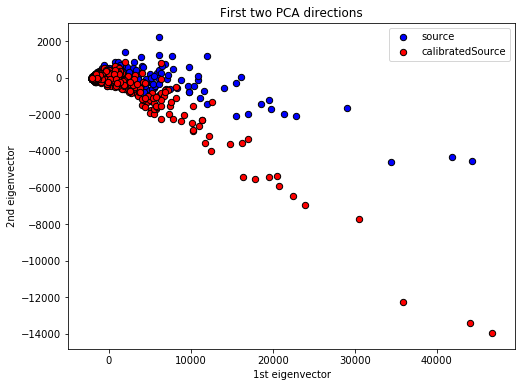

In [80]:
fig = plot_pca_2d(source, calibratedSource)
#fig.savefig("calibration_scRNA_counts.png", pad_inches = 0, dpi = 300, )